In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import Compose, ToTensor, Normalize
import torchvision.transforms.v2 as transforms
from PIL import Image
from tqdm import tqdm
from typing import Tuple, Union, Any
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import CIFAR10
from tqdm import tqdm
from typing import Tuple
from torchvision.models import detection
import os
import numpy as np
import warnings
from torchmetrics.detection.mean_ap import MeanAveragePrecision
warnings.filterwarnings('ignore')
from torchmetrics import Accuracy, Precision, Recall, F1Score
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [2]:
# Utils functions
def set_seed(seed: int) -> None:
    """
    Define a seed for reproducibility. It allows experiment repetition obtaining the exact same results.
    :param seed: integer number indicating which seed you want to use.
    :return: None.
    """
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)  # Numpy module.
    # random.seed(seed)  # Python random module.
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

def get_inner_model(model: detection) -> Any:
    """
    PyTorch provides a model wrapper to enable multiple GPUs. This function returns the inner model (without wrapper).
    :param model: Torch model, with or without nn.DataParallel wrapper.
    :return: if model is wrapped, it returns the inner model (model.module). Otherwise, it returns the input model.
    """
    return model.module if isinstance(model, torch.nn.DataParallel) else model

def torch_load_cpu(load_path: str) -> Any:
    """
    Load the data saved from a trained model (model weights, optimizer state, last epoch number to resume training...)
    :param load_path: string indicating the path to the data saved from a trained model.
    :return: dictionary containing data saved from a trained model.
    """
    return torch.load(load_path, map_location=lambda storage, loc: storage)  # Load on CPU

def load_model_path(path: str, model: detection, device: torch.device, optimizer: torch.optim = None) -> Tuple[Any, Any, int]:
    """
    Load the trained weights of a model into the given model.
    :param path: string indicating the path to the trained weights of a model.
    :param model: the model where you want to load the weights.
    :param device: whether gpu or cpu is being used.
    :param optimizer: the optimizer initialized before loading the weights.
    :return:
        model: Torchvision model.
        optimizer: Torch optimizer.
        initial_epoch: first epoch number.
    """

    # Load model state
    load_data = torch_load_cpu(path)
    model_ = get_inner_model(model)
    model_.load_state_dict({**model_.state_dict(), **load_data.get('model', {})})

    # Load rng state
    torch.set_rng_state(load_data['rng_state'])
    if torch.cuda.is_available():
        torch.cuda.set_rng_state_all(load_data['cuda_rng_state'])

    # Load optimizer state
    if 'optimizer' in load_data and optimizer is not None:
        optimizer.load_state_dict(load_data['optimizer'])
        for state in optimizer.state.values():
            for k, v in state.items():
                if torch.is_tensor(v):
                    state[k] = v.to(device)

    # Get initial epoch
    initial_epoch = load_data['initial_epoch']

    return model, optimizer, initial_epoch
def torchvision_model(model_name: str, pretrained: bool = False, num_classes: int = 2) -> Any:
    """
    Return a model from a list of Torchvision models.
    :param model_name: name of the Torchvision model that you want to load.
    :param pretrained: whether pretrained weights are going to be loaded or not.
    :param num_classes: number of classes. Minimum is 2: 0 = background, 1 = object.
    :return:
        model: Torchvision model.
    """

    # Torchvision models
    model_dict = {
        'faster_rcnn_v1': detection.fasterrcnn_resnet50_fpn,
        'faster_rcnn_v2': detection.fasterrcnn_resnet50_fpn_v2,
        'faster_rcnn_v3': detection.fasterrcnn_mobilenet_v3_large_fpn,
        'faster_rcnn_v4': detection.fasterrcnn_mobilenet_v3_large_320_fpn,
        'fcos_v1': detection.fcos_resnet50_fpn,
        'retinanet_v1': detection.retinanet_resnet50_fpn,
        'retinanet_v2': detection.retinanet_resnet50_fpn_v2,
        'ssd_v1': detection.ssd300_vgg16,
        'ssd_v2': detection.ssdlite320_mobilenet_v3_large,
    }

    # Create model and load pretrained weights (if pretrained=True)
    if model_name in model_dict:
        model = model_dict[model_name](weights='COCO_V1' if pretrained else None)

        # Modify the model's output layer for the number of classes in your dataset
        if 'faster_rcnn' in model_name:
            in_features = model.roi_heads.box_predictor.cls_score.in_features
            model.roi_heads.box_predictor = detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
        elif 'retinanet' in model_name:
            in_features = model.head.classification_head.cls_logits.in_channels
            num_anchors = model.head.classification_head.num_anchors
            model.head.classification_head = detection.retinanet.RetinaNetClassificationHead(
                in_features, num_anchors, num_classes
            )
        elif 'fcos' in model_name:
            in_features = model.head.classification_head.cls_logits.in_channels
            num_anchors = model.head.classification_head.num_anchors
            model.head.classification_head = detection.fcos.FCOSClassificationHead(
                in_features, num_anchors, num_classes
            )
        elif 'ssd_v1' in model_name:
            in_features = [module.in_channels for module in model.head.classification_head.module_list]
            num_anchors = model.anchor_generator.num_anchors_per_location()
            model.head.classification_head = detection.ssd.SSDClassificationHead(
                in_features, num_anchors, num_classes
            )
        elif 'ssd_v2' in model_name:
            in_features = [module[0][0].in_channels for module in model.head.classification_head.module_list]
            num_anchors = model.anchor_generator.num_anchors_per_location()
            model.head.classification_head = detection.ssd.SSDClassificationHead(
                in_features, num_anchors, num_classes
            )

    # Error: Model not in list
        else:
            assert False, 'Model {} not in list. Indicate a Torchvision model from the list.'.format(model_name)
    else:
        assert False, 'Model {} not in list. Indicate a Torchvision model from the list.'.format(model_name)

    return model

def get_model(model_name: str, model_path: str = '', num_classes: int = 2,
              lr_data: list = None, pretrained: bool = False,
              use_gpu: bool = False) -> Tuple[Any, Any, int, torch.device]:
    """
    Main function to create and load the model.
    :param model_name: name of the Torchvision model to load.
    :param model_path: path to the model.
    :param num_classes: number of classes. Minimum is 2: 0 = background, 1 = object.
    :param lr_data: list containing [learning rate, learning rate momentum, learning rate decay].
    :param pretrained: whether Torch pretrained weights on COCO dataset are going to be used or not.
    :param use_gpu: whether to use GPU or CPU.
    :return:
        model: Torch model.
        optimizer: Torch optimizer.
        initial_epoch: first epoch number.
        device: torch device indicating whether to use GPU or CPU.
    """

    # Define device (GPU or CPU)
    device_name = 'cuda' if use_gpu and torch.cuda.is_available() else 'cpu'
    device = torch.device(device_name)

    # Load Torchvision model
    model = torchvision_model(model_name, pretrained, num_classes).to(device)
    if use_gpu and torch.cuda.is_available() and torch.cuda.device_count() > 1:
        model = torch.nn.DataParallel(model).cuda()

    # Define the optimizer
    if lr_data:
        params = [p for p in model.parameters() if p.requires_grad]
        optimizer = torch.optim.SGD(params, lr=lr_data[0], momentum=lr_data[1], weight_decay=lr_data[2])
    else:
        optimizer = None

    # Load trained weights, optimizer state, and initial epoch
    if os.path.isfile(model_path):
        print('  [*] Loading Torch model from {}'.format(model_path))
        model, optimizer, initial_epoch = load_model_path(model_path, model, device, optimizer)
    else:
        initial_epoch = 0
        print('Weights not found')

    return model, optimizer, initial_epoch, device

In [3]:
# Data functions
class CustomDataset(Dataset):

    def __init__(self, path_dataset: str, resize_shape: tuple = None, transform: transforms.Compose = None) -> None:
        """
        Custom dataset that feeds the network during train, validation, and test.
        :param path_dataset: path to the dataset.
        :param resize_shape: tuple indicating height and width to resize images (for faster performance).
        :param transform: list of transforms to apply to the images.
        """
        self.annotations = parse_annotations(path_dataset)
        self.resize_shape = resize_shape
        self.transform = transform

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, dict]:
        """
        Get an index corresponding to one of the images and return the image and its annotation.
        :param idx: index of image to load.
        :return:
            image: Torch tensor containing the image with shape (Channels, Height, Width).
            targets: dictionary with the bounding boxes (boxes) and class labels (labels) of each annotated object.
        """
        # Get one annotation for the current index
        annotation = self.annotations[idx]

        # Load image
        image = Image.open(annotation['path_image']).convert("RGB")

        # Load bounding boxes
        boxes = self.annotations[idx]['boxes']
        boxes = torch.Tensor(boxes)

        # Load labels (class of the object)
        labels = self.annotations[idx]['labels']
        labels = torch.Tensor(labels).type(torch.int64)  # Specify that labels are int

        # Apply transforms
        if self.transform:
            w, h = image.size
            image, boxes, class_labels = self.transform(image, boxes, labels)
            if self.resize_shape:
                boxes = resize_boxes(boxes, self.resize_shape, (h, w))

        # Torchvision models use this structure for boxes and labels
        targets = {'boxes': boxes, 'labels': torch.Tensor(labels)}

        return image, targets

    def __len__(self) -> int:
        """
        Length of the dataset.
        :return: number of annotated images contained in the dataset.
        """
        return len(self.annotations)


def resize_boxes(boxes: torch.Tensor, resize_shape: tuple, image_shape: tuple) -> torch.Tensor:
    """
    Resize the shape of the bounding boxes when the size of the images is also resized.
    :param boxes: Torch tensor containing bounding boxes with format: [x_min, y_min, x_max, y_max].
    :param resize_shape: new image size.
    :param image_shape: previous image size.
    :return:
        boxes: resized bounding boxes.
    """
    boxes[:, 0] *= resize_shape[1] / image_shape[1]
    boxes[:, 1] *= resize_shape[0] / image_shape[0]
    boxes[:, 2] *= resize_shape[1] / image_shape[1]
    boxes[:, 3] *= resize_shape[0] / image_shape[0]
    return boxes


def get_transform(norm: tuple, resize_shape: Union[tuple, None]) -> transforms.Compose:
    """
    Define data transformations and apply them to the dataset.
    :param norm: mean and std required by each Torchvision model to normalize the input images.
    :param resize_shape: new image size.
    :return:
        transform: list of transforms to apply to the images.
    """

    # Convert images to Torch tensors and apply the previous normalization
    t = [transforms.ToTensor(), transforms.Normalize(*norm)]

    # Resize images if required
    if resize_shape:
        t.append(transforms.Resize(resize_shape))
    return transforms.Compose(t)



def parse_annotations(path_dataset: str) -> list:
    """
    Read dataset structure and extract path to images and annotations.
    :param path_dataset: path to the dataset.
    :return:
        annotations: list of dictionaries, each with the path to the image, the bounding boxes, and the class labels.
    """

    # Search labels on each sequence
    annotations = []
    for sequence in sorted(os.listdir(path_dataset)):
        if os.path.isdir(os.path.join(path_dataset, sequence)):
            path_sequence = os.path.join(path_dataset, sequence, 'annotations')
            # Search labels on each frame
            for frame in sorted(os.listdir(path_sequence)):
                if frame.endswith(".txt"):
                    path_frame_labels = os.path.join(path_sequence, frame)
                    # Load labels
                    image_name, boxes, labels = read_content(path_frame_labels)

                    # Get path to the image
                    path_image = os.path.join(path_dataset, sequence, 'images', image_name)
    
                    # Save the path to the image, the boxes, and the labels (class of object) in a dictionary
                    annotations.append({
                        'path_image': path_image,
                        'boxes': np.array(boxes),
                        'labels': np.array(labels)
                    })
    return annotations


def read_content(txt_file: str) -> Tuple[str, list]:
    """
    Read annotation txt file.
    :param txt_file: path to txt file.
    :return:
        image_name: string with the image filename.
        list_with_all_boxes: list of bounding boxes.
    """

    # Initialize variables to store data
    image_name = os.path.basename(txt_file).split('.')[0] + ".jpg"  # Use filename as image name
     
    list_with_all_boxes = []
    list_with_all_labels = []

    # Read txt data
    with open(txt_file, 'r') as f:
        lines = f.readlines()

        # Extract bounding boxes
        for line in lines[0:]:
            bbox_data = line.strip().split(',')
            xmin = int(bbox_data[0])
            ymin = int(bbox_data[1])
            xmax = xmin + int(bbox_data[2])  # Calculate xmax from width
            ymax = ymin + int(bbox_data[3])  # Calculate ymax from height

            list_with_single_boxes = [xmin, ymin, xmax, ymax]
            list_with_all_boxes.append(list_with_single_boxes)

            label = int(bbox_data[5])
            list_with_all_labels.append(label)

    return image_name, list_with_all_boxes, list_with_all_labels


def collate_fn(batch: list) -> tuple:
    """
    Avoids stacking images and annotations from dataloader as a Torch tensor, and stacks them as tuples.
    :param batch: images and annotations loaded from dataset.
    :return:
        batch: images and annotations stacked as tuples.
    """
    return tuple(zip(*batch))

In [16]:
# Data parameters
path_dataset_test = '/home/Dataset/Test'                   

# Model parameters
model_name = 'faster_rcnn_v2'                                               # Torchvision model
model_path = f'/home/Models/{model_name}/faster_rcnn_v2.pt' # Path to save trained model
num_classes = 12                                                             # Number of classes (ALWAYS 2: 0=background, 1=robot)
resize_shape = (1280, 720)                                                         # Resize images for faster performance. None to avoid resizing
pretrained = True                                                           # Use weights pre-trained on COCO dataset

# Train parameters
batch_size = 4                                                              # Batch size
use_gpu = True                                                              # Use GPU (True) or CPU (False)

# Other parameters (do not change)
num_workers = 4

In [17]:
# Load model
model, _, _, device = get_model(
    model_name, model_path, num_classes, None, pretrained, use_gpu
)

  [*] Loading Torch model from /home/jovyan/ALBERTO/Pruebas_Pytorch/models/faster_rcnn_v2/model_faster_rcnn_v2_SGD_1280x720_00001.pt


In [18]:
data_test = CustomDataset(path_dataset_test, resize_shape, transform=get_transform(
    (get_inner_model(model).transform.image_mean, get_inner_model(model).transform.image_std), resize_shape
))

# Initialize your dataloader
test_loader = DataLoader(
    data_test, batch_size=batch_size, shuffle=True, num_workers=num_workers, collate_fn=collate_fn
)


In [78]:
%%time
# Set model in eval mode (no gradients)
model.eval()

# Evaluate (gradients are not necessary)
predictions_list, targets_list = [], []
with torch.no_grad():

    # Evaluate
    print('Test:')
    for images, targets in tqdm(test_loader):

        # Move data to device
        images = torch.stack(images, dim=0).to(device)
        targets = [{k: v.to(device) for k, v in targets[t].items()} for t in range(len(images))]
        targets_list.extend(targets)

        # Predict and get loss value
        predictions = model(images)
        predictions_list.extend(predictions)

    # Metrics
    metrics = MeanAveragePrecision()(predictions_list, targets_list)
    print('\nmAP: {}'.format(metrics['map']))
    print('mAP@0.50: {}'.format(metrics['map_50']))
    print('mAP@0.75: {}'.format(metrics['map_75']))
    print('mAP@Small: {}'.format(metrics['map_small']))
    print('mAP@Medium: {}'.format(metrics['map_medium']))
    print('mAP@Large: {}'.format(metrics['map_large']))

Test:


100%|██████████| 403/403 [00:49<00:00,  8.22it/s]



mAP: 0.00023804540978744626
mAP@0.50: 0.0009926347993314266
mAP@0.75: 1.0402123734820634e-05
mAP@Small: 0.00023393359151668847
mAP@Medium: 0.00046352046774700284
mAP@Large: 0.00024532832321710885
CPU times: user 4min 23s, sys: 2min 14s, total: 6min 38s
Wall time: 1min 32s


In [22]:
def test(model, test_loader, device):
    # Set model to evaluation mode
    model.eval()
    
    # Initialize lists to store predictions and targets
    predictions_list, targets_list = [], []
    
    # No gradients required for evaluation
    with torch.no_grad():
        print('Test:')
        for images, targets in tqdm(test_loader):
            # Move data to device
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            targets_list.extend(targets)
            
            # Predict
            predictions = model(images)
            predictions_list.extend(predictions)
    
    # Initialize metrics
    accuracy_metric = Accuracy(task='multiclass', num_classes=12)
    precision_metric = Precision(task='multiclass', average='macro', num_classes=12)
    recall_metric = Recall(task='multiclass', average='macro', num_classes=12)
    f1_metric = F1Score(task='multiclass', average='macro', num_classes=12)

    # Calculate metrics for each image
    for pred, target in zip(predictions_list, targets_list):
        pred_labels = pred['labels'].cpu()
        true_labels = target['labels'].cpu()
        
        # Ensure that pred_labels and true_labels have the same length
        min_length = min(len(pred_labels), len(true_labels))
        pred_labels = pred_labels[:min_length]
        true_labels = true_labels[:min_length]
        
        accuracy_metric.update(pred_labels, true_labels)
        precision_metric.update(pred_labels, true_labels)
        recall_metric.update(pred_labels, true_labels)
        f1_metric.update(pred_labels, true_labels)
    
    # Compute metrics
    accuracy = accuracy_metric.compute()
    precision = precision_metric.compute()
    recall = recall_metric.compute()
    f1 = f1_metric.compute()

    print('\nAccuracy: {}'.format(accuracy.item()))
    print('F1 Score: {}'.format(f1.item()))
    print('Recall: {}'.format(recall.item()))
    print('Precision: {}'.format(precision.item()))

    return {
        'accuracy': accuracy.item(),
        'f1_score': f1.item(),
        'recall': recall.item(),
        'precision': precision.item()
    }

# Example usage:
test_results = test(model, test_loader, device)


Test:


100%|██████████| 403/403 [00:31<00:00, 12.70it/s]



Accuracy: 0.3729596734046936
F1 Score: 0.10738934576511383
Recall: 0.11425961554050446
Precision: 0.11964458227157593


Test:


100%|██████████| 403/403 [02:00<00:00,  3.34it/s]



mAP: 0.10030219703912735
mAP@0.50: 0.18544897437095642
mAP@0.75: 0.09737055748701096
mAP@Small: 0.053143616765737534
mAP@Medium: 0.17257867753505707
mAP@Large: 0.25477638840675354
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
43.0 5291.0 558.0 77.0 18.0 2.0 0.0 2.0 4.0 0.0 293.0 2.0 5767.0
2.0 55.0 436.0 7.0 0.0 0.0 0.0 0.0 0.0 0.0 38.0 0.0 584.0
0.0 0.0 0.0 37.0 0.0 0.0 0.0 2.0 3.0 0.0 11.0 0.0 44.0
49.0 51.0 24.0 9.0 19568.0 2136.0 233.0 111.0 103.0 156.0 412.0 23.0 11241.0
0.0 3.0 0.0 0.0 863.0 1420.0 112.0 6.0 16.0 181.0 2.0 5.0 1675.0
0.0 1.0 0.0 1.0 164.0 149.0 653.0 34.0 84.0 138.0 1.0 34.0 1407.0
0.0 0.0 0.0 1.0 0.0 0.0 1.0 24.0 9.0 0.0 3.0 1.0 33.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0 45.0 182.0 290.0 2.0 3.0 1282.0 0.0 4.0 1120.0
38.0 46.0 59.0 189.0 8.0 1.0 2.0 34.0 10.0 0.0 1088.0 4.0 1004.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
2048.0 15559.0 5299.0 981.0 7408.0 1881.0 1368.0 315.0 367.0 1183.0 3997.0 192.0 0.0


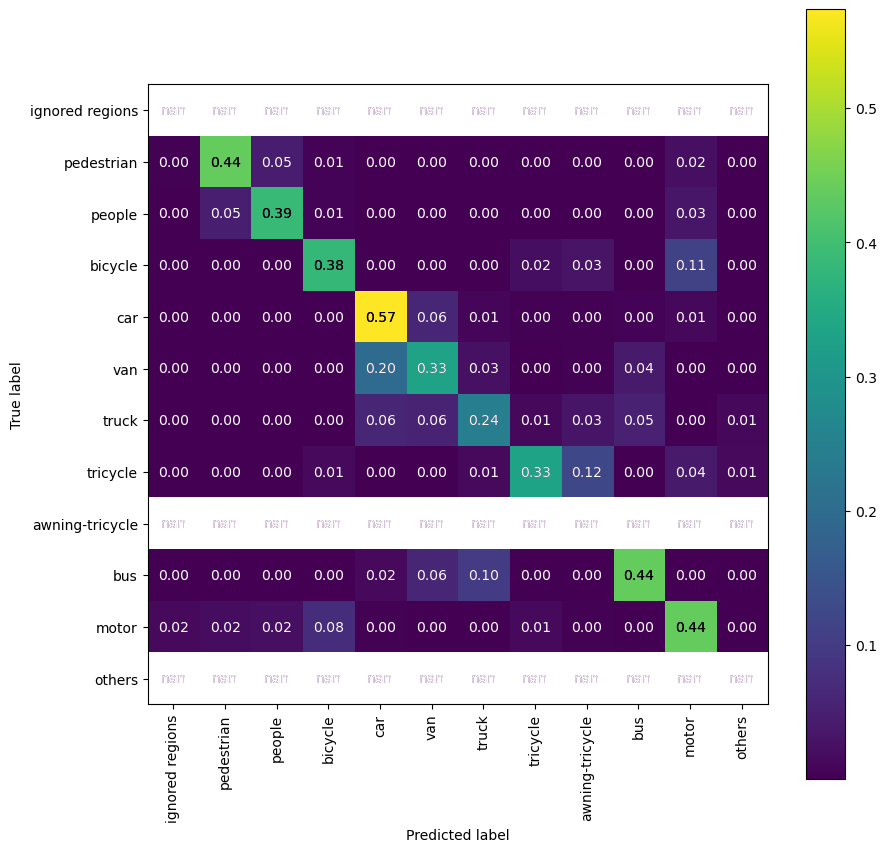

In [19]:

CLASSES = [
    "ignored regions", "pedestrian", "people", "bicycle", "car",
    "van", "truck", "tricycle", "awning-tricycle", "bus", "motor", "others", "unmatched"
]

# Función para calcular IoU
def box_iou_calc(boxes1, boxes2):
    def box_area(box):
        return (box[2] - box[0]) * (box[3] - box[1])

    area1 = box_area(boxes1.T)
    area2 = box_area(boxes2.T)

    lt = np.maximum(boxes1[:, None, :2], boxes2[:, :2])  # [N,M,2]
    rb = np.minimum(boxes1[:, None, 2:], boxes2[:, 2:])  # [N,M,2]

    inter = np.prod(np.clip(rb - lt, a_min=0, a_max=None), 2)
    return inter / (area1[:, None] + area2 - inter)  # iou = inter / (area1 + area2 - inter)

# Clase para la matriz de confusión
class ConfusionMatrix:
    def __init__(self, num_classes: int, CONF_THRESHOLD=0.3, IOU_THRESHOLD=0.5):
        self.matrix = np.zeros((num_classes + 1, num_classes + 1))
        self.num_classes = num_classes
        self.CONF_THRESHOLD = CONF_THRESHOLD
        self.IOU_THRESHOLD = IOU_THRESHOLD

    def process_batch(self, detections, labels: np.ndarray):
        gt_classes = labels[:, 0].astype(np.int16)

        try:
            detections = detections[detections[:, 4] > self.CONF_THRESHOLD]
        except IndexError or TypeError:
            for i, label in enumerate(labels):
                gt_class = gt_classes[i]
                self.matrix[self.num_classes, gt_class] += 1
            return

        detection_classes = detections[:, 5].astype(np.int16)

        all_ious = box_iou_calc(labels[:, 1:], detections[:, :4])
        want_idx = np.where(all_ious > self.IOU_THRESHOLD)

        all_matches = [[want_idx[0][i], want_idx[1][i], all_ious[want_idx[0][i], want_idx[1][i]]] for i in range(want_idx[0].shape[0])]

        all_matches = np.array(all_matches)
        if all_matches.shape[0] > 0:
            all_matches = all_matches[all_matches[:, 2].argsort()[::-1]]

            all_matches = all_matches[np.unique(all_matches[:, 1], return_index=True)[1]]

            all_matches = all_matches[all_matches[:, 2].argsort()[::-1]]

            all_matches = all_matches[np.unique(all_matches[:, 0], return_index=True)[1]]

        for i, label in enumerate(labels):
            gt_class = gt_classes[i]
            if all_matches.shape[0] > 0 and all_matches[all_matches[:, 0] == i].shape[0] == 1:
                detection_class = detection_classes[int(all_matches[all_matches[:, 0] == i, 1][0])]
                self.matrix[detection_class, gt_class] += 1
            else:
                self.matrix[self.num_classes, gt_class] += 1

        for i, detection in enumerate(detections):
            if not all_matches.shape[0] or (all_matches.shape[0] and all_matches[all_matches[:, 1] == i].shape[0] == 0):
                detection_class = detection_classes[i]
                self.matrix[detection_class, self.num_classes] += 1

    def return_matrix(self):
        return self.matrix

    def print_matrix(self):
        for i in range(self.num_classes + 1):
            print(' '.join(map(str, self.matrix[i])))

# Set model in eval mode (no gradients)
model.eval()

# Initialize the confusion matrix
num_classes = 12
conf_matrix = ConfusionMatrix(num_classes=num_classes)

# Evaluate (gradients are not necessary)
predictions_list, targets_list = [], []
with torch.no_grad():
    print('Test:')
    for images, targets in tqdm(test_loader):
        images = torch.stack(images, dim=0).to(device)
        targets = [{k: v.to(device) for k, v in targets[t].items()} for t in range(len(images))]
        targets_list.extend(targets)

        predictions = model(images)
        predictions_list.extend(predictions)

        for target, prediction in zip(targets, predictions):
            true_labels = []
            for label, box in zip(target['labels'], target['boxes']):
                true_labels.append([label.item()] + box.cpu().numpy().tolist())
            true_labels = np.array(true_labels)

            pred_labels = []
            for label, box, score in zip(prediction['labels'], prediction['boxes'], prediction['scores']):
                pred_labels.append(box.cpu().numpy().tolist() + [score.item(), label.item()])
            pred_labels = np.array(pred_labels)

            conf_matrix.process_batch(pred_labels, true_labels)

    metrics = MeanAveragePrecision()(predictions_list, targets_list)
    print('\nmAP: {}'.format(metrics['map']))
    print('mAP@0.50: {}'.format(metrics['map_50']))
    print('mAP@0.75: {}'.format(metrics['map_75']))
    print('mAP@Small: {}'.format(metrics['map_small']))
    print('mAP@Medium: {}'.format(metrics['map_medium']))
    print('mAP@Large: {}'.format(metrics['map_large']))

# Mostrar la matriz de confusión
conf_matrix.print_matrix()

# Normalizar la matriz de confusión
matrix = conf_matrix.return_matrix()
normalized_matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Añadir una pequeña cantidad a los valores cero para asegurar que se muestren
normalized_matrix[normalized_matrix == 0] = 1e-6

# Visualizar la matriz de confusión
fig, ax = plt.subplots(figsize=(10, 10))  # Aumentar el tamaño de la figura
disp = ConfusionMatrixDisplay(confusion_matrix=normalized_matrix[:-1, :-1], display_labels=CLASSES[:-1])
disp.plot(cmap=plt.cm.viridis, ax=ax, values_format='.2f', xticks_rotation=90)  # Ajustar el formato de los valores y la rotación de las etiquetas

# Ajustar el tamaño de la fuente de los números
for labels in disp.text_.ravel():
    labels.set_fontsize(10)

# Asegurar que todos los números se muestren con dos decimales
for i in range(normalized_matrix.shape[0] - 1):
    for j in range(normalized_matrix.shape[1] - 1):
        value = normalized_matrix[i, j]
        ax.text(j, i, f'{value:.2f}', ha="center", va="center", color="black" if value > 0.35 else "white")

# Save the figure
output_path = '/home/jovyan/ALBERTO/Pytorch_Flower/ConfusionMatrix.png'
plt.savefig(output_path)

# Show the figure
plt.show()

